## 1- Load the data

In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df_covid = pd.read_csv('large_data.csv')  # Replace 'your_dataset.csv' with the actual file path or name

# Display the first few rows to verify the data was loaded correctly
print(df_covid.head())

   COUGH  MUSCLE_ACHES  TIREDNESS  SORE_THROAT  RUNNY_NOSE  STUFFY_NOSE  \
0      0             0          1            0           1            0   
1      0             0          1            0           0            0   
2      0             1          1            1           0            0   
3      0             0          0            1           1            0   
4      0             0          1            0           1            0   

   FEVER  NAUSEA  VOMITING  DIARRHEA  ...  DIFFICULTY_BREATHING  \
0      0       0         0         0  ...                     0   
1      0       0         0         0  ...                     0   
2      0       0         0         0  ...                     0   
3      0       0         0         0  ...                     0   
4      0       0         0         0  ...                     0   

   LOSS_OF_TASTE  LOSS_OF_SMELL  ITCHY_NOSE  ITCHY_EYES  ITCHY_MOUTH  \
0              1              0           1           0            0   
1 

## 2- Keeping features that coinciding with second dataset

In [2]:
columns_to_drop = ['ITCHY_NOSE', 'ITCHY_EYES', 'ITCHY_MOUTH', 'ITCHY_INNER_EAR', 'PINK_EYE', 'NAUSEA', 'VOMITING', 'SHORTNESS_OF_BREATH', 'LOSS_OF_TASTE', 'LOSS_OF_SMELL', 'SNEEZING']
df_common = df_covid.drop(columns=columns_to_drop)

In [3]:
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44453 entries, 0 to 44452
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 44453 non-null  int64 
 1   MUSCLE_ACHES          44453 non-null  int64 
 2   TIREDNESS             44453 non-null  int64 
 3   SORE_THROAT           44453 non-null  int64 
 4   RUNNY_NOSE            44453 non-null  int64 
 5   STUFFY_NOSE           44453 non-null  int64 
 6   FEVER                 44453 non-null  int64 
 7   DIARRHEA              44453 non-null  int64 
 8   DIFFICULTY_BREATHING  44453 non-null  int64 
 9   TYPE                  44453 non-null  object
dtypes: int64(9), object(1)
memory usage: 3.4+ MB


## 3- Correlation with class label

### Mutual Information

In [4]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Calculate mutual information between each binary feature and the label
X = df_common.iloc[:, :-1]  # Features (all columns except the label)
y = df_common['TYPE']  # Label column

# Compute mutual information scores
mi_scores = mutual_info_classif(X, y, discrete_features=True)

# Organize scores into a DataFrame for easy reading
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

                Feature  Mutual Information
8  DIFFICULTY_BREATHING            0.209883
7              DIARRHEA            0.209016
6                 FEVER            0.193483
4            RUNNY_NOSE            0.033222
5           STUFFY_NOSE            0.033164
0                 COUGH            0.000664
2             TIREDNESS            0.000619
1          MUSCLE_ACHES            0.000607
3           SORE_THROAT            0.000589


## 4- Correlation among features

### Cramer's V (more proper for categorical data) 

In [5]:
# 0 --> no association
# 1 --> strong association

'''
0.1 or lower: Weak association.
0.1 to 0.3: Moderate association.
Above 0.3: Strong association.
'''

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Function to calculate Cramér's V
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()  # Total sample size
    k = min(contingency_table.shape) - 1  # Smaller dimension minus 1
    return np.sqrt(chi2 / (n * k))

df = df_common.iloc[:, :-1]

# Create an empty DataFrame to store the Cramér's V values
cramers_v_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate Cramér's V for each pair of features
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Perfect association with itself
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Convert values to float for better display
cramers_v_matrix = cramers_v_matrix.astype(float)

print("Cramér's V Matrix:")
print(cramers_v_matrix)


Cramér's V Matrix:
                         COUGH  MUSCLE_ACHES  TIREDNESS  SORE_THROAT  \
COUGH                 1.000000      0.006706   0.006086     0.006312   
MUSCLE_ACHES          0.006706      1.000000   0.005834     0.005070   
TIREDNESS             0.006086      0.005834   1.000000     0.007333   
SORE_THROAT           0.006312      0.005070   0.007333     1.000000   
RUNNY_NOSE            0.004034      0.004858   0.003415     0.003783   
STUFFY_NOSE           0.005218      0.004692   0.004240     0.004699   
FEVER                 0.013179      0.013371   0.012223     0.012108   
DIARRHEA              0.011637      0.009224   0.011155     0.008148   
DIFFICULTY_BREATHING  0.009617      0.005767   0.009908     0.008829   

                      RUNNY_NOSE  STUFFY_NOSE     FEVER  DIARRHEA  \
COUGH                   0.004034     0.005218  0.013179  0.011637   
MUSCLE_ACHES            0.004858     0.004692  0.013371  0.009224   
TIREDNESS               0.003415     0.004240  0.0122

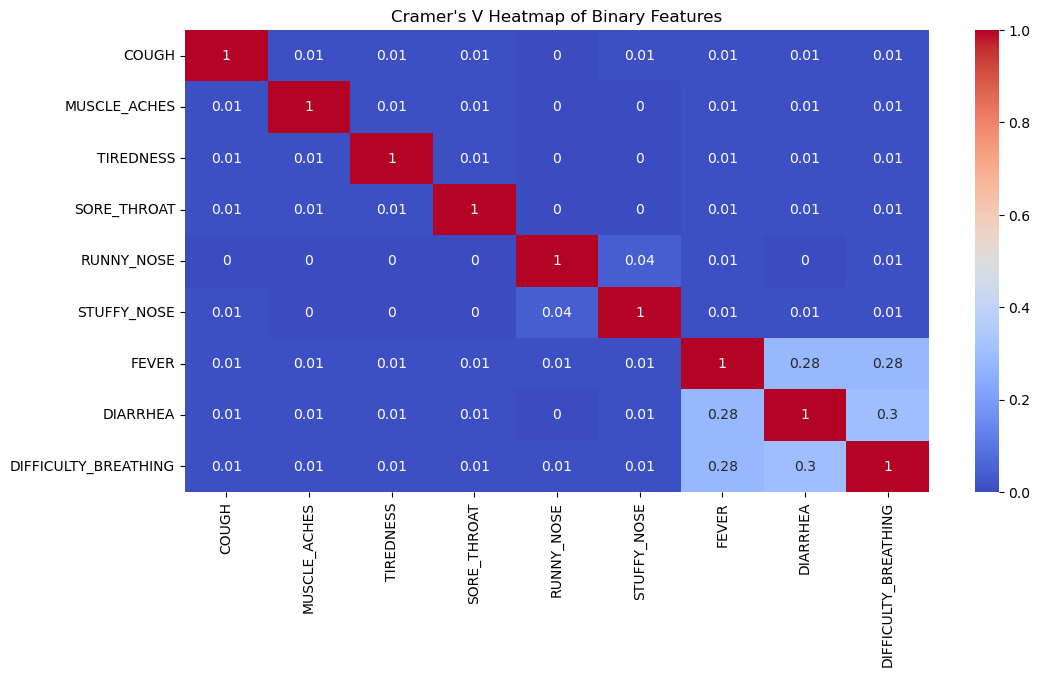

In [7]:
# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cramers_v_matrix.round(2), annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramer's V Heatmap of Binary Features")
plt.show()

## 6- Feature Importance (Decision Tree)

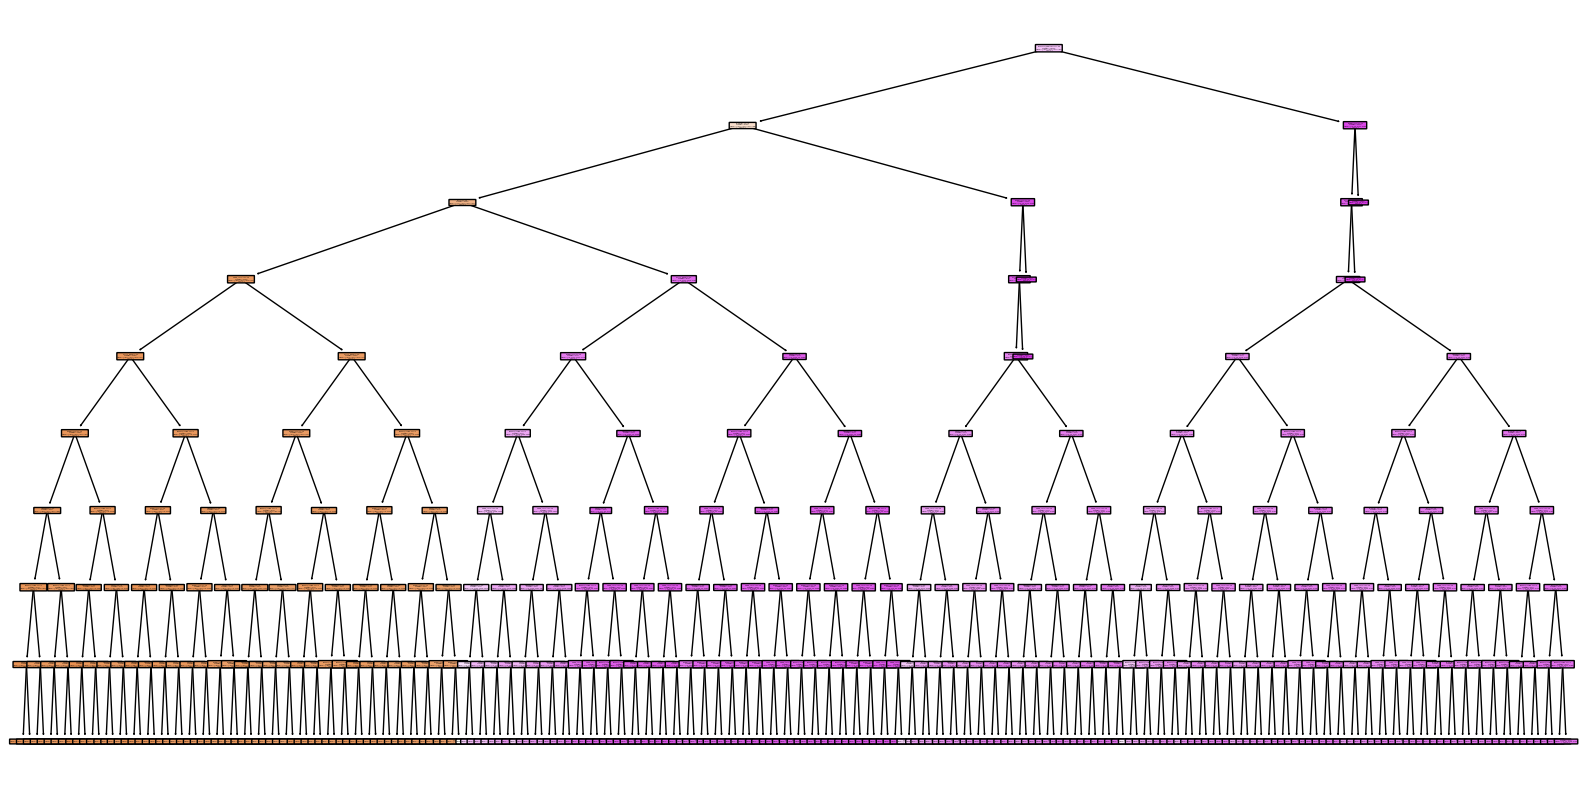

In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Step 1: Load the Data
# data = pd.read_csv("your_dataset.csv")

# Assuming the last column is the target label
X = df_common.iloc[:, :-1]  # Features
y = df_common.iloc[:, -1]   # Labels

# Step 2: Encode labels if necessary
# For categorical labels, you may use label encoding if they are not numeric:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Step 3: Build an overfitted Decision Tree
tree = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1)
tree.fit(X, y)

# Step 4: Visualize the Tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=[str(c) for c in tree.classes_], 
          proportion=True, rounded=True, impurity=False)
plt.show()

In [9]:
# Step 1: Extract the split feature indices and store them in the order they appear
feature_indices = tree.tree_.feature
feature_names = X.columns

# Step 2: Filter out leaf nodes (-2 indicates a leaf node)
split_feature_indices = feature_indices[feature_indices != -2]

# Step 3: Map the indices to feature names and list their order
split_feature_names = [feature_names[i] for i in split_feature_indices]

# Display the order of features used for splits
print("Order of features used at splits (from root to leaves):")
print(split_feature_names)

# Step 4: Count the usage of each feature in the tree
feature_usage_counts = Counter(split_feature_names)
print("\nFeature usage count:")
print(feature_usage_counts)

Order of features used at splits (from root to leaves):
['DIFFICULTY_BREATHING', 'DIARRHEA', 'FEVER', 'SORE_THROAT', 'STUFFY_NOSE', 'RUNNY_NOSE', 'TIREDNESS', 'MUSCLE_ACHES', 'COUGH', 'COUGH', 'MUSCLE_ACHES', 'COUGH', 'COUGH', 'MUSCLE_ACHES', 'TIREDNESS', 'COUGH', 'COUGH', 'COUGH', 'TIREDNESS', 'TIREDNESS', 'MUSCLE_ACHES', 'RUNNY_NOSE', 'COUGH', 'TIREDNESS', 'TIREDNESS', 'TIREDNESS', 'COUGH', 'COUGH', 'TIREDNESS', 'RUNNY_NOSE', 'COUGH', 'COUGH', 'COUGH', 'RUNNY_NOSE', 'RUNNY_NOSE', 'STUFFY_NOSE', 'RUNNY_NOSE', 'MUSCLE_ACHES', 'COUGH', 'TIREDNESS', 'TIREDNESS', 'COUGH', 'TIREDNESS', 'TIREDNESS', 'COUGH', 'MUSCLE_ACHES', 'TIREDNESS', 'TIREDNESS', 'TIREDNESS', 'MUSCLE_ACHES', 'MUSCLE_ACHES', 'MUSCLE_ACHES', 'RUNNY_NOSE', 'TIREDNESS', 'COUGH', 'COUGH', 'TIREDNESS', 'COUGH', 'COUGH', 'COUGH', 'RUNNY_NOSE', 'TIREDNESS', 'TIREDNESS', 'TIREDNESS', 'RUNNY_NOSE', 'RUNNY_NOSE', 'STUFFY_NOSE', 'RUNNY_NOSE', 'MUSCLE_ACHES', 'SORE_THROAT', 'TIREDNESS', 'COUGH', 'COUGH', 'COUGH', 'TIREDNESS', 'TIREDN

NameError: name 'Counter' is not defined